In [ ]:
!pip install opencv-python matplotlib imageio tensorflow

In [ ]:
!pip install tensorflow-macos tensorflow-metal # Only for macOS

## Importing all the necessary dependencies

In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from typing import List

In [14]:
# Memory growth limit
gpu = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.expermimental.set_memory_growth(gpu[0], True)
except:
    pass
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # Isolating the mouth region in the video (better way would be using DLib. See LipNet paper)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [18]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [21]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [35]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [26]:
def load_data(path:str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [27]:
test_path = './data/s1/bbal6n.mpg'

In [38]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

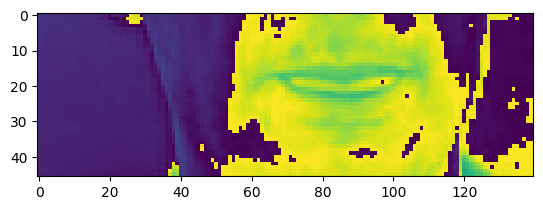

In [51]:
plt.imshow(frames[10])

In [52]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [54]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result